In [1]:
!pip install beir
!pip install elasticsearch
!pip install -U sentence-transformers
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200

In [2]:
from beir import util
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.search.lexical import BM25Search as BM25
from beir.retrieval.evaluation import EvaluateRetrieval
from beir.retrieval.search.dense import DenseRetrievalExactSearch as DRES
from beir.retrieval import models

import pathlib, os, string
from tqdm.notebook import tqdm

import spacy

import time
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
import string

from sentence_transformers import SentenceTransformer

import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Application running on {device}")

/usr/local/lib/python3.9/dist-packages/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Application running on cuda


## Download and setup the Elasticsearch instance

In [3]:
%%bash

wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512
tar -xzf elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
sudo chown -R daemon:daemon elasticsearch-7.9.2/
shasum -a 512 -c elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512 

elasticsearch-oss-7.9.2-linux-x86_64.tar.gz: OK


In [4]:
%%bash --bg

sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch

In [5]:
for i in tqdm(range(20), desc = 'Let the Elasticsearch instance start'): time.sleep(1)

Let the Elasticsearch instance start:   0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
%%bash

ps -ef | grep elasticsearch

root        1004    1002  0 12:24 ?        00:00:00 sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch
daemon      1006    1004 29 12:24 ?        00:00:17 /content/elasticsearch-7.9.2/jdk/bin/java -Xshare:auto -Des.networkaddress.cache.ttl=60 -Des.networkaddress.cache.negative.ttl=10 -XX:+AlwaysPreTouch -Xss1m -Djava.awt.headless=true -Dfile.encoding=UTF-8 -Djna.nosys=true -XX:-OmitStackTraceInFastThrow -XX:+ShowCodeDetailsInExceptionMessages -Dio.netty.noUnsafe=true -Dio.netty.noKeySetOptimization=true -Dio.netty.recycler.maxCapacityPerThread=0 -Dio.netty.allocator.numDirectArenas=0 -Dlog4j.shutdownHookEnabled=false -Dlog4j2.disable.jmx=true -Djava.locale.providers=SPI,COMPAT -Xms1g -Xmx1g -XX:+UseG1GC -XX:G1ReservePercent=25 -XX:InitiatingHeapOccupancyPercent=30 -Djava.io.tmpdir=/tmp/elasticsearch-8362894097621837181 -XX:+HeapDumpOnOutOfMemoryError -XX:HeapDumpPath=data -XX:ErrorFile=logs/hs_err_pid%p.log -Xlog:gc*,gc+age=trace,safepoint:file=logs/gc.log:utctime,pid,tags:filecou

In [9]:
%%bash

curl -sX GET "localhost:9200/"

{
  "name" : "c70e2e953aed",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "izoOw2u1Q8iMAOzhKFjqfQ",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "oss",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


# Available Datasets

| Dataset   | Website| BEIR-Name | Domain     | Relevancy| Queries  | Documents | Avg. Docs/Q | Download | 
| -------- | -----| ---------| ----------- | ---------| ---------| --------- | ------| ------------| 
| MSMARCO    | [``Homepage``](https://microsoft.github.io/msmarco/)| ``msmarco`` | Misc.       |  Binary  |  6,980   |  8.84M     |    1.1 | Yes |  
| TREC-COVID |  [``Homepage``](https://ir.nist.gov/covidSubmit/index.html)| ``trec-covid``| Bio-Medical |  3-level|50|  171K| 493.5 | Yes | 
| NFCorpus   | [``Homepage``](https://www.cl.uni-heidelberg.de/statnlpgroup/nfcorpus/) | ``nfcorpus``  | Bio-Medical |  3-level |  323     |  3.6K     |  38.2 | Yes |
| BioASQ     | [``Homepage``](http://bioasq.org) | ``bioasq``| Bio-Medical |  Binary  |   500    |  14.91M    |  8.05 | No | 
| NQ         | [``Homepage``](https://ai.google.com/research/NaturalQuestions) | ``nq``| Wikipedia   |  Binary  |  3,452   |  2.68M  |  1.2 | Yes | 
| HotpotQA   | [``Homepage``](https://hotpotqa.github.io) | ``hotpotqa``| Wikipedia   |  Binary  |  7,405   |  5.23M  |  2.0 | Yes |
| FiQA-2018  | [``Homepage``](https://sites.google.com/view/fiqa/) | ``fiqa``    | Finance     |  Binary  |  648     |  57K    |  2.6 | Yes | 
| Signal-1M (RT) | [``Homepage``](https://research.signal-ai.com/datasets/signal1m-tweetir.html)| ``signal1m`` | Twitter     |  3-level  |   97   |  2.86M  |  19.6 | No |
| TREC-NEWS  | [``Homepage``](https://trec.nist.gov/data/news2019.html) | ``trec-news``    | News     |  5-level  |   57    |  595K    |  19.6 | No |
| ArguAna    | [``Homepage``](http://argumentation.bplaced.net/arguana/data) | ``arguana`` | Misc.       |  Binary  |  1,406     |  8.67K    |  1.0 | Yes |
| Touche-2020| [``Homepage``](https://webis.de/events/touche-20/shared-task-1.html) | ``webis-touche2020``| Misc.       |  6-level  |  49     |  382K    |  49.2 |  Yes |
| CQADupstack| [``Homepage``](http://nlp.cis.unimelb.edu.au/resources/cqadupstack/) | ``cqadupstack``| StackEx.      |  Binary  |  13,145 |  457K  |  1.4 |  Yes |
| Quora| [``Homepage``](https://www.quora.com/q/quoradata/First-Quora-Dataset-Release-Question-Pairs) | ``quora``| Quora  | Binary  |  10,000     |  523K    |  1.6 |  Yes | 
| DBPedia | [``Homepage``](https://github.com/iai-group/DBpedia-Entity/) | ``dbpedia-entity``| Wikipedia |  3-level  |  400    |  4.63M    |  38.2 |  Yes | 
| SCIDOCS| [``Homepage``](https://allenai.org/data/scidocs) | ``scidocs``| Scientific |  Binary  |  1,000     |  25K    |  4.9 |  Yes | 
| FEVER| [``Homepage``](http://fever.ai) | ``fever``| Wikipedia     |  Binary  |  6,666     |  5.42M    |  1.2|  Yes | 
| Climate-FEVER| [``Homepage``](http://climatefever.ai) | ``climate-fever``| Wikipedia |  Binary  |  1,535     |  5.42M |  3.0 |  Yes |
| SciFact| [``Homepage``](https://github.com/allenai/scifact) | ``scifact``| Scientific |  Binary  |  300     |  5K    |  1.1 |  Yes |


# Data Loading

In [10]:
# Importing drive to download or update datasets
from google.colab import drive
drive.mount('/content/drive/')
preprocessed_drive_path = '/content/drive/MyDrive/preprocessed_datasets'

Mounted at /content/drive/


In [11]:
def download_dataset(dataset):
  '''
  PURPOSE: download the dataset
  ARGUMENSTS:
    - dataset: string describing the beir dataset
  RETURN: documents, queries, qrels of the respective dataset
  '''
  data_path = f'datasets/{dataset}'
  if not os.path.isdir(data_path):
    url = f'https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset}.zip'
    out_dir = os.path.join(os.getcwd(), 'datasets')
    data_path = util.download_and_unzip(url, out_dir)
    print(f'Dataset downloaded here: {data_path}')
  return GenericDataLoader(data_path).load(split="test")


datasets = ['scifact', 'nfcorpus'] # Choosen datasets

datasets_data = {}
number_k_prime_values = 10

for dataset in datasets:
  corpus, queries, qrels = download_dataset(dataset)
  datasets_data[dataset] = {
      'corpus': corpus,
      'queries': queries,
      'qrels': qrels
  }

k_prime_values = {dataset: [i for i in range(1, (len(data['corpus']) + 1), (len(data['corpus']) + 1)//number_k_prime_values)] for dataset, data in datasets_data.items()}
k_ground_truth = {dataset: [1, 10, 100, 1000] for dataset in datasets}

/content/datasets/scifact.zip:   0%|          | 0.00/2.69M [00:00<?, ?iB/s]

Dataset downloaded here: /content/datasets/scifact


  0%|          | 0/5183 [00:00<?, ?it/s]

/content/datasets/nfcorpus.zip:   0%|          | 0.00/2.34M [00:00<?, ?iB/s]

Dataset downloaded here: /content/datasets/nfcorpus


  0%|          | 0/3633 [00:00<?, ?it/s]

In [12]:
def print_res(score_dict):
  '''
  PURPOSE: print the score results of the retreived embedding
  ARGUMENTS:
    - score_dict: dictionary containing the score
  RETRUN: None
  '''
  for score, res in score_dict.items():
    print(score)
    for k, r in res.items():
      print(f'\t{k}\t->\t{r}') # k: score@k r: score
    print('\n')

# Document Pre-Processing

In [13]:
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
clean_tokens = lambda tokens : ' '.join([token.lemma_.lower() if token not in stopwords and not token.is_punct else '' for token in tokens])

In [14]:
def pre_process(elem_to_preprocess):
  '''
  PURPOSE: preprocess the text using spaCy
  ARGUMENTS:
    - elem_to_preprocess: dictionary of title and text or only text
  RETRUN: key document/query with cleaned text
  '''
  key, val = elem_to_preprocess
  if type(val) is dict: # Is a document
    return key, {
        'title': clean_tokens(nlp(val['title'])), # Cleaning the title document
        'text': clean_tokens(nlp(val['text'])) # Cleaning the text document
    }
  else: return key, clean_tokens(nlp(val)) # Cleaning the query text


def query_documents_preprocessing(dataset_name, documents, queries):
  '''
  PORPUSE: preprocess all the documents and query for the relative dataset
  ARGUMENTS:
    - dataset_name:string describing the dataset name
    - documents: dictionary/list of documents
    - queries: dicotionary/list of queries
  RETRUN: 
    - new_documents: dictionary of cleaned documents
    - new_queries dictionary of cleaned queries
  '''
  new_queries = {}
  new_documents = {}

  for text, iter, res in zip(('Documents', 'Queries'), (documents, queries), (new_documents, new_queries)):
    with ProcessPoolExecutor(max_workers=mp.cpu_count()) as executor:
      for id, query_doc in list(tqdm(executor.map(pre_process, iter.items()),
                                     total=len(iter.items()), desc=f'{dataset_name} - {text} Pre-Processing')):
        res[id] = query_doc

  return new_documents, new_queries


pre_processed_data = {} # Dictionary of dataset: pre_processed_corpus and pre_processed_queries
path_datasets = os.path.join(os.getcwd(), 'datasets')
for dataset, values in datasets_data.items():

  pre_proc_corpus, pre_proc_queries = None, None

  # In case we have already the pre_preocessed data files uploaded as .parquet we load those files
  if(os.path.isdir(os.path.join(preprocessed_drive_path, dataset)) and len(os.listdir(os.path.join(preprocessed_drive_path, dataset))) == 2):
    pre_proc_corpus = pd.read_parquet(os.path.join(preprocessed_drive_path, dataset, 'pre_processed_corpus.parquet')).to_dict(orient='index')
    pre_proc_queries = pd.read_parquet(os.path.join(preprocessed_drive_path, dataset, 'pre_processed_queries.parquet')).to_dict()[0]

    print(f'{dataset} - Loaded Pre-Processed Documents and Queries')
    
  else: # Otherwise we compute the pre_processing step
    pre_proc_corpus, pre_proc_queries = query_documents_preprocessing(dataset, values['corpus'], values['queries'])
  
  pre_processed_data[dataset] = { # Populate the dictionary
      'pre_processed_corpus': pre_proc_corpus,
      'pre_processed_queries': pre_proc_queries
  }

scifact - Loaded Pre-Processed Documents and Queries
nfcorpus - Loaded Pre-Processed Documents and Queries


# Embedding

In [15]:
def embeddings(model, corpus, queries, qrels, k_values):
  '''
  PURPOSE: getting the specific embedding using the given model
  ARGUMENTS:
    - model: specify the model to use
    - corpus: sequence of documents 
    - queries: sequence of queries
    - qrels: ground truth of query document relevance
    - k_values: list of top k documents to return
  RETURN:
    - results: vector of results
    - {'ndcg': ndcg, 'map': _map, 'recall': recall, 'precision': precision}: dictionary of scores
  '''
  retriever = EvaluateRetrieval(model, score_function='dot', k_values=k_values) # Setting the retreiver

  # Retrieve dense results
  results = retriever.retrieve(corpus, queries)

  ndcg, _map, recall, precision = retriever.evaluate(qrels, results, k_values) # Getting the scores
  return results, {'ndcg': ndcg, 'map': _map, 'recall': recall, 'precision': precision}

## Sparse Embeddings with BM25

In [16]:
def sparse_embeddings_bm25(dataset_name, corpus, queries, qrels, k_primes):
  '''
  PURPOSE: compute the sparse embedding using the BM25 implementation from beir and elastichsearch
  ARGUMENTS:
    - dataset_name: string describing the dataset name
    - corpus: sequence of documents 
    - queries: sequence of queries
    - qrels: ground truth of query document relevance
    - k_primes: list of number of top k prime documents to return
  RETURN: see embeddings return values
  '''
  hostname = 'localhost' 
  index_name = dataset_name
  initialize = True # Delete existing index with same name and reindex all documents

  print(f'{dataset_name} - BM25')
  model = BM25(index_name=index_name, hostname=hostname, initialize=initialize) # Defining the BM25
  return embeddings(model, corpus, queries, qrels, k_primes)

sparse_datasets_embeddings = {}
for dataset, pre_pro_data in pre_processed_data.items(): # For each dataset compute the BM25
  sparse_vector, sparse_score_dict = sparse_embeddings_bm25(dataset, pre_pro_data['pre_processed_corpus'],
                                                            pre_pro_data['pre_processed_queries'], datasets_data[dataset]['qrels'], 
                                                            k_prime_values[dataset])
  print(f'\nSparse retrieved evaluation for k in: {k_prime_values[dataset]}')
  print_res(sparse_score_dict) # Printing the scores results
  sparse_datasets_embeddings[dataset] = { # Populating the disctionary with the resulting vector and scores
      'sparse_vector': sparse_vector,
      'sparse_score_dict': sparse_score_dict
  }

scifact - BM25


que: 100%|██████████| 3/3 [00:35<00:00, 11.74s/it]



Sparse retrieved evaluation for k in: [1, 519, 1037, 1555, 2073, 2591, 3109, 3627, 4145, 4663, 5181]
ndcg
	NDCG@1	->	0.58
	NDCG@519	->	0.72198
	NDCG@1037	->	0.72303
	NDCG@1555	->	0.72303
	NDCG@2073	->	0.72364
	NDCG@2591	->	0.72364
	NDCG@3109	->	0.72393
	NDCG@3627	->	0.72393
	NDCG@4145	->	0.72393
	NDCG@4663	->	0.72393
	NDCG@5181	->	0.72393


map
	MAP@1	->	0.55928
	MAP@519	->	0.65218
	MAP@1037	->	0.65219
	MAP@1555	->	0.65219
	MAP@2073	->	0.6522
	MAP@2591	->	0.6522
	MAP@3109	->	0.6522
	MAP@3627	->	0.6522
	MAP@4145	->	0.6522
	MAP@4663	->	0.6522
	MAP@5181	->	0.6522


recall
	Recall@1	->	0.55928
	Recall@519	->	0.97
	Recall@1037	->	0.98
	Recall@1555	->	0.98
	Recall@2073	->	0.98667
	Recall@2591	->	0.98667
	Recall@3109	->	0.99
	Recall@3627	->	0.99
	Recall@4145	->	0.99
	Recall@4663	->	0.99
	Recall@5181	->	0.99


precision
	P@1	->	0.58
	P@519	->	0.00212
	P@1037	->	0.00107
	P@1555	->	0.00071
	P@2073	->	0.00054
	P@2591	->	0.00043
	P@3109	->	0.00036
	P@3627	->	0.00031
	P@4145	->	0.00027
	P@4663	->	

que: 100%|██████████| 3/3 [00:09<00:00,  3.10s/it]


Sparse retrieved evaluation for k in: [1, 364, 727, 1090, 1453, 1816, 2179, 2542, 2905, 3268, 3631]
ndcg
	NDCG@1	->	0.45292
	NDCG@364	->	0.30556
	NDCG@727	->	0.31779
	NDCG@1090	->	0.32385
	NDCG@1453	->	0.3283
	NDCG@1816	->	0.33051
	NDCG@2179	->	0.3316
	NDCG@2542	->	0.33213
	NDCG@2905	->	0.33233
	NDCG@3268	->	0.33233
	NDCG@3631	->	0.33233


map
	MAP@1	->	0.06094
	MAP@364	->	0.15999
	MAP@727	->	0.16122
	MAP@1090	->	0.16168
	MAP@1453	->	0.16192
	MAP@1816	->	0.16202
	MAP@2179	->	0.16206
	MAP@2542	->	0.16209
	MAP@2905	->	0.16209
	MAP@3268	->	0.16209
	MAP@3631	->	0.16209


recall
	Recall@1	->	0.06094
	Recall@364	->	0.33728
	Recall@727	->	0.3764
	Recall@1090	->	0.39535
	Recall@1453	->	0.41149
	Recall@1816	->	0.42058
	Recall@2179	->	0.42574
	Recall@2542	->	0.42818
	Recall@2905	->	0.42949
	Recall@3268	->	0.42949
	Recall@3631	->	0.42949


precision
	P@1	->	0.47078
	P@364	->	0.02631
	P@727	->	0.01527
	P@1090	->	0.01098
	P@1453	->	0.0086
	P@1816	->	0.00701
	P@2179	->	0.00589
	P@2542	->	0.00508
	P

## Dense Embeddings with SentenceBert and all-MiniLM-L6-v2

In [17]:
def dense_embeddings_sbert(dataset_name, corpus, queries, qrels, k_primes):
  '''
  PURPOSE: compute the dense embedding using the SBERT implementation from beir and the all-MiniLM-L6-v2 sentence transformer
  ARGUMENTS:
    - dataset_name: string describing the dataset name
    - corpus: sequence of documents 
    - queries: sequence of queries
    - qrels: ground truth of query document relevance
    - k_primes: list of number of top k prime documents to return
  RETURN: see embeddings return values
  '''
  model = DRES(models.SentenceBERT('all-MiniLM-L6-v2'), batch_size=16) # Defining the SentenceBert model
  print(f'{dataset_name} - SBERT')
  return embeddings(model, corpus, queries, qrels, k_primes)

dense_datasets_embeddings = {} 
for dataset, pre_pro_data in pre_processed_data.items(): # For each dataset compute the SentenceBert
  dense_vector, dense_score_dict = dense_embeddings_sbert(dataset, pre_pro_data['pre_processed_corpus'],
                                                          pre_pro_data['pre_processed_queries'], datasets_data[dataset]['qrels'],
                                                          k_prime_values[dataset])
  print(f'\nDense retreived evaluation for k in: {k_prime_values[dataset]}')
  print_res(dense_score_dict) # Printing the scores results
  dense_datasets_embeddings[dataset] = { # Populating the disctionary with the resulting vector and scores
      'dense_vector': dense_vector,
      'dense_score_dict': dense_score_dict
  }

scifact - SBERT


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/324 [00:00<?, ?it/s]


Dense retreived evaluation for k in: [1, 519, 1037, 1555, 2073, 2591, 3109, 3627, 4145, 4663, 5181]
ndcg
	NDCG@1	->	0.51667
	NDCG@519	->	0.68865
	NDCG@1037	->	0.69008
	NDCG@1555	->	0.69008
	NDCG@2073	->	0.69008
	NDCG@2591	->	0.69008
	NDCG@3109	->	0.69037
	NDCG@3627	->	0.69037
	NDCG@4145	->	0.69037
	NDCG@4663	->	0.69037
	NDCG@5181	->	0.69037


map
	MAP@1	->	0.49833
	MAP@519	->	0.60964
	MAP@1037	->	0.60966
	MAP@1555	->	0.60966
	MAP@2073	->	0.60966
	MAP@2591	->	0.60966
	MAP@3109	->	0.60967
	MAP@3627	->	0.60967
	MAP@4145	->	0.60967
	MAP@4663	->	0.60967
	MAP@5181	->	0.60967


recall
	Recall@1	->	0.49833
	Recall@519	->	0.98333
	Recall@1037	->	0.99667
	Recall@1555	->	0.99667
	Recall@2073	->	0.99667
	Recall@2591	->	0.99667
	Recall@3109	->	1.0
	Recall@3627	->	1.0
	Recall@4145	->	1.0
	Recall@4663	->	1.0
	Recall@5181	->	1.0


precision
	P@1	->	0.51667
	P@519	->	0.00215
	P@1037	->	0.00109
	P@1555	->	0.00072
	P@2073	->	0.00054
	P@2591	->	0.00043
	P@3109	->	0.00036
	P@3627	->	0.00031
	P@4145	->	0.0

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Batches:   0%|          | 0/228 [00:00<?, ?it/s]


Dense retreived evaluation for k in: [1, 364, 727, 1090, 1453, 1816, 2179, 2542, 2905, 3268, 3631]
ndcg
	NDCG@1	->	0.3839
	NDCG@364	->	0.32497
	NDCG@727	->	0.35799
	NDCG@1090	->	0.38265
	NDCG@1453	->	0.40183
	NDCG@1816	->	0.41717
	NDCG@2179	->	0.43112
	NDCG@2542	->	0.44408
	NDCG@2905	->	0.45484
	NDCG@3268	->	0.46524
	NDCG@3631	->	0.47445


map
	MAP@1	->	0.03849
	MAP@364	->	0.14861
	MAP@727	->	0.15241
	MAP@1090	->	0.15445
	MAP@1453	->	0.15582
	MAP@1816	->	0.15693
	MAP@2179	->	0.15784
	MAP@2542	->	0.15862
	MAP@2905	->	0.15927
	MAP@3268	->	0.15986
	MAP@3631	->	0.16041


recall
	Recall@1	->	0.03849
	Recall@364	->	0.43544
	Recall@727	->	0.54602
	Recall@1090	->	0.63714
	Recall@1453	->	0.71316
	Recall@1816	->	0.77008
	Recall@2179	->	0.82689
	Recall@2542	->	0.87802
	Recall@2905	->	0.92308
	Recall@3268	->	0.96431
	Recall@3631	->	0.99984


precision
	P@1	->	0.40248
	P@364	->	0.03645
	P@727	->	0.02467
	P@1090	->	0.01973
	P@1453	->	0.01682
	P@1816	->	0.01501
	P@2179	->	0.01365
	P@2542	->	0.01262


# Ground truth at k

In [18]:
def ground_truth_merging(dataset_name, sparse_vector, dense_vector, k_truth):
  '''
  PURPOSE: obtaning theground truth from the sparse and sense embeddings
  ARGUMENTS:
    - dataset_name: string describing the dataset name
    - sparse_vector: sparse embedding vector
    - dense_vector: dense embedding vector
    - k_truth: list of number of top k documents to return
  RETURN:
   - ground_truth: dictionary og the following form:
      {
        k_value: {
          query_id: {
            doc_id: 1
            doc_id: 1
            ...
          },
          ...
        },
        ...
      }
  '''
  ground_truth = {}

  for k in tqdm(k_truth, total=len(k_truth), desc=f'{dataset_name} - Retriving the ground truth'):

    ground_truth[k] = {}

    for (query, sparse_dic), (_, dense_dic) in zip(sparse_vector.items(), dense_vector.items()):
      
      ground_truth[k][query] = {} # Initialize the dictionary

      # Sorting the vector by score
      scores = {doc_id: sparse_dic.get(doc_id, 0) + dense_dic.get(doc_id, 0) for doc_id in set(sparse_dic.keys()) | set(dense_dic.keys())}
      sorted_score = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True)[0:k])

      # Populating the dictionary
      ground_truth[k][query] = {doc_id: 1 for doc_id in list(sorted_score.keys())}
  
  return ground_truth

datasets_ground_truth_k = {} # Dictionary of ground truth with key dataset name and value the reative ground truth
for (dataset, sparse_elem), (_, dense_elem) in zip(sparse_datasets_embeddings.items(), dense_datasets_embeddings.items()):
  datasets_ground_truth_k[dataset] = ground_truth_merging(dataset, sparse_elem['sparse_vector'], dense_elem['dense_vector'], k_ground_truth[dataset]) #k_values[dataset]

scifact - Retriving the ground truth:   0%|          | 0/4 [00:00<?, ?it/s]

nfcorpus - Retriving the ground truth:   0%|          | 0/4 [00:00<?, ?it/s]

# Merging Dense and Sparse Embeddings

In [28]:
def merging_top_k(dataset_name, sparse_vector, dense_vector, k_primes):
  '''
  PURPOSE: merging the top k document for each query by making the union of the scores
  ARGUMENTS:
    - dataset_name: string describing the dataset name
    - sparse_vector: sparse embedding vector
    - dense_vector: dense embedding vector
    - k_primes: list of number of top k prime documents to return
  RETURN:
    - merged_vector: dictionary of the following form:
      {
        k: {
          query_id: {
            doc_id: score,
            doc_id: score
            ...
          },
          ...
        },
        ...
      }
  '''
  merged_vector = {}
  sorted_dict = {}

  for (query, sparse_dic), (_, dense_dic) in zip(sparse_vector.items(), dense_vector.items()):
    sorted_dict[query] = {
        'sorted_sparse_score': sorted(sparse_dic.items(), key=lambda item: item[1], reverse=True),
        'sorted_dense_score': sorted(dense_dic.items(), key=lambda item: item[1], reverse=True),
        'groud_truth_scores': {doc_id: sparse_dic.get(doc_id, 0) + dense_dic.get(doc_id, 0) for doc_id in set(sparse_dic.keys()) | set(dense_dic.keys())},
        'sparse_dic': sparse_dic,
        'dense_dic': dense_dic
    }


  for k in k_primes:

    merged_vector[k] = {}

    for query, vector in sorted_dict.items():

      merged_vector[k][query] = {}

      for doc_id in set(dict(vector['sorted_sparse_score'][0:k])) | set(dict(vector['sorted_dense_score'][0:k])):
        sparse_value = vector['sparse_dic'].get(doc_id, 0)
        dense_value = vector['dense_dic'].get(doc_id, 0)
        if sparse_value == 0: sparse_value = vector['groud_truth_scores'].get(doc_id, 0)
        if dense_value == 0: dense_value = vector['groud_truth_scores'].get(doc_id, 0)
        merged_vector[k][query][doc_id] = sparse_value + dense_value

  return merged_vector


datasets_merged_k_prime_vector = {} # Dictionary of merged top k vector for each dataset
for (dataset, sparse_elem), (_, dense_elem) in zip(sparse_datasets_embeddings.items(), dense_datasets_embeddings.items()):
  datasets_merged_k_prime_vector[dataset] = merging_top_k(dataset, sparse_elem['sparse_vector'], dense_elem['dense_vector'], k_prime_values[dataset])

# Evaluating the top k respect the ground truth

In [29]:
def evaluate_top_k(dataset_name, merged_k_prime_vector, ground_truth_k):
  '''
  PURPOSE: evaluate each merged top k prime vectors with each vectors of theground truth at k 
  ARGUMENTS:
    - dataset_name: string describing the dataset name
    - merged_k_prime_vector: dictionary of the merged embeddings
    - ground_truth_k: dictionary of the ground truth
    - k_primes: list of number of top k prime documents to return
  RETURN:
  '''
  evaluate_top_k_results = {}

  # For each ground truth vectors
  for k, ground_truth in tqdm(ground_truth_k.items(), total=len(ground_truth_k.items()),
                              desc=f"{dataset_name} - Evaluating top k' merged embeddings with the top k ground truth vector"):
    
    ndcg_list, map_list, recall_list, precision_list = [], [], [], [] 

    # For each merged vectors
    for _, merged_result in merged_k_prime_vector.items():

      # We obtain the score at the top k
      ndcg, _map, recall, precision = EvaluateRetrieval.evaluate(ground_truth, merged_result, k_values=[k])

      ndcg_list.append(ndcg[f'NDCG@{k}'])
      map_list.append(_map[f'MAP@{k}'])
      recall_list.append(recall[f'Recall@{k}'])
      precision_list.append(precision[f'P@{k}'])

    # Populate the dictionary with all scores for the k_prime documents
    evaluate_top_k_results[k] = {'ndcg': ndcg_list, 'map': map_list, 'recall': recall_list, 'precision': precision_list}

  return evaluate_top_k_results

res_evaluate_top_k_prime = {} # Dictionary initialization

for dataset, top_k_list in k_ground_truth.items():
  res_evaluate_top_k_prime[dataset] = {}
  for k in top_k_list:
    res_evaluate_top_k_prime[dataset][k] = {'ndcg': {}, 'map':{}, 'recall': {}, 'precision': {}}

for (dataset, merged_elem), (_, g_truth_elem) in zip(datasets_merged_k_prime_vector.items(), datasets_ground_truth_k.items()):
  for k, results in evaluate_top_k(dataset, merged_elem, g_truth_elem).items():
    for score, res in results.items():
      res_evaluate_top_k_prime[dataset][k][score] = res # Dictionary population

scifact - Evaluating top k' merged embeddings with the top k ground truth vector:   0%|          | 0/4 [00:00<…

nfcorpus - Evaluating top k' merged embeddings with the top k ground truth vector:   0%|          | 0/4 [00:00…

# Viewing scores

In [30]:
import matplotlib.pyplot as plt
from google.colab import widgets

def print_graph_scores(datasets, res_evaluate_top_k_prime, str_score):
  '''
  PURPOSE: print the graph with the relative scores of the top k_prime respect the top k
  ARGUMENTS:
    - datasets: list of dataset names
    - res_evaluate_top_k_prime: dictionary containing the score for each dataset, k 
    - str_score: score string
  RETURN: None
  '''

  tb = widgets.TabBar([f'{dataset} - {str_score.capitalize()}' for dataset in datasets])

  for id_r, dataset in enumerate(datasets):
    with tb.output_to(id_r, select=(i == 0)):
      plt.figure(figsize=(10,5))
      for k, scores in res_evaluate_top_k_prime[dataset].items():
        plot, = plt.plot(k_prime_values[dataset], scores[str_score], label=f'Ground Trurh Top k@{k}')

        my_xticks = [f"k'@{k}" for k in k_prime_values[dataset]]
        plt.xticks(k_prime_values[dataset], my_xticks)

      plt.xlabel('Retreived Top K')
      plt.ylabel(str_score.capitalize())
      plt.title(f'{dataset} - {str_score.capitalize()}')
      plt.legend()
      plt.grid(True)
      plt.show()

## NDCG

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

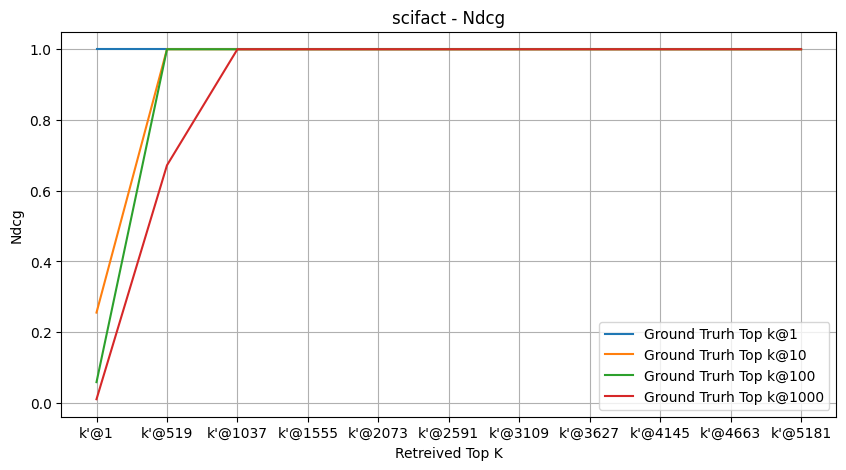

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

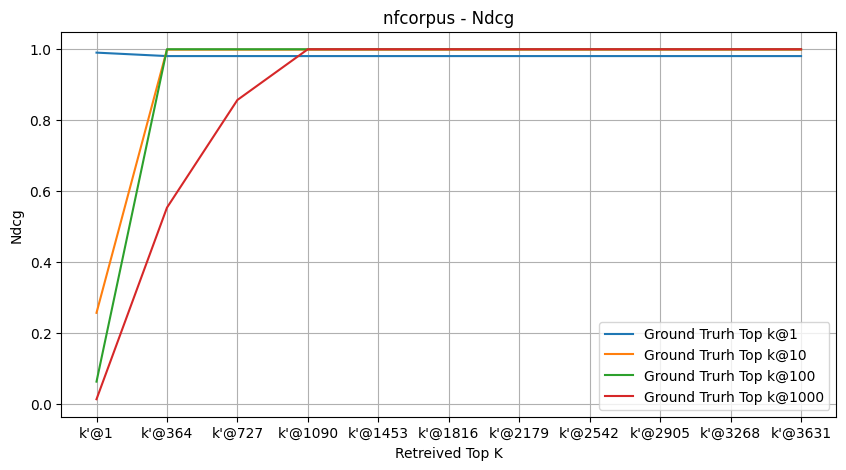

<IPython.core.display.Javascript object>

In [31]:
print_graph_scores(datasets, res_evaluate_top_k_prime, 'ndcg')

## MAP

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

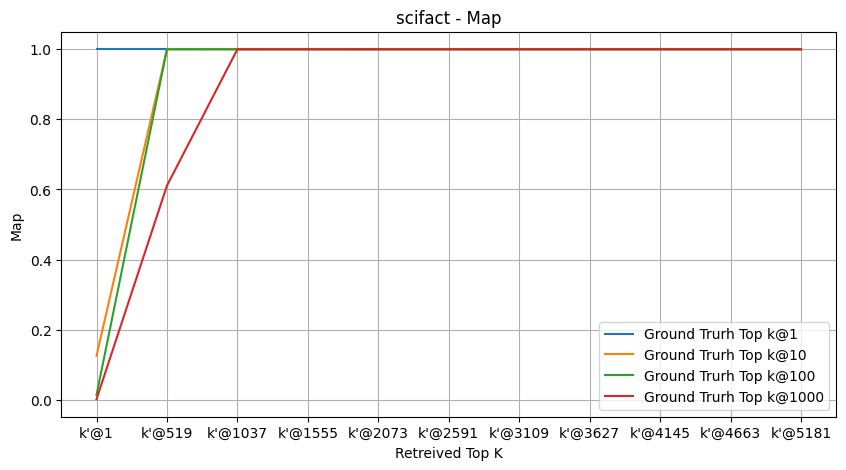

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

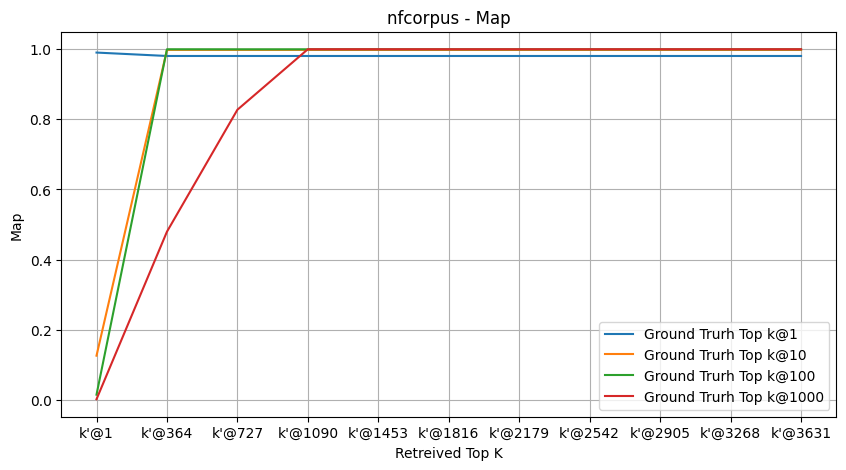

<IPython.core.display.Javascript object>

In [32]:
print_graph_scores(datasets, res_evaluate_top_k_prime, 'map')

## Recall

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

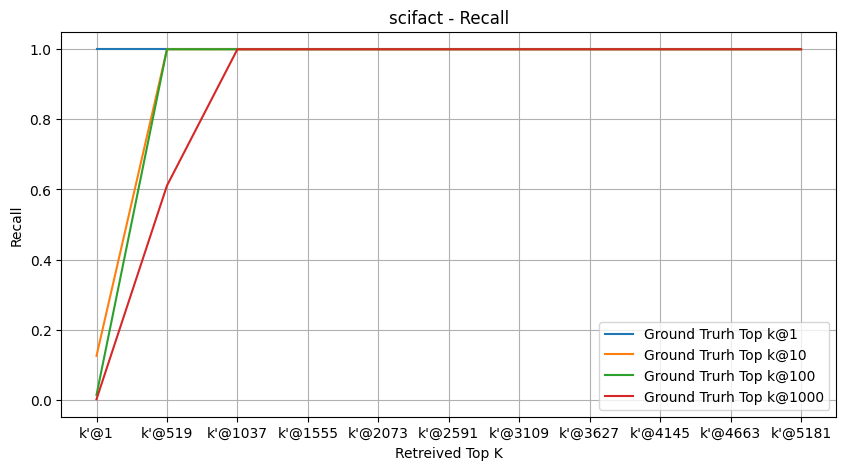

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

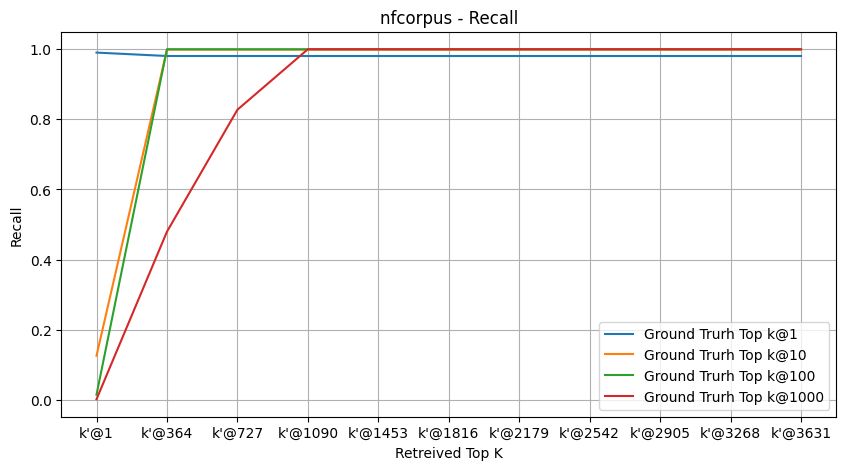

<IPython.core.display.Javascript object>

In [33]:
print_graph_scores(datasets, res_evaluate_top_k_prime, 'recall')

## Precision

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

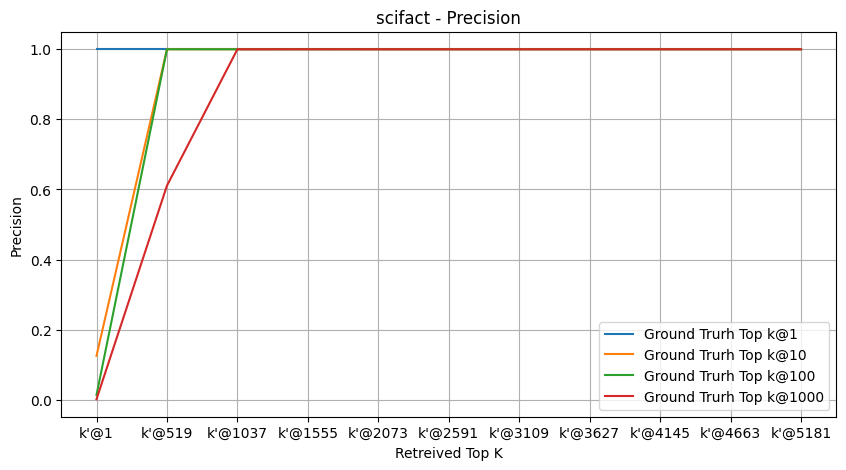

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

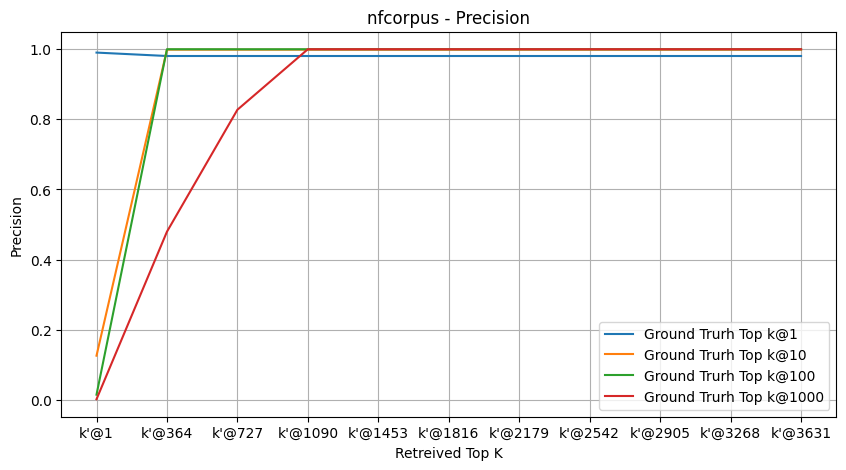

<IPython.core.display.Javascript object>

In [34]:
print_graph_scores(datasets, res_evaluate_top_k_prime, 'precision')